In [440]:
import numpy as np
from heat import *
import matplotlib.pyplot as plt
from scipy.signal import detrend
import pickle as pkl
from DTS_processing_functions import *
from matplotlib.pyplot import cm
import matplotlib.animation as animation
import emcee
import corner
import multiprocessing as mp
from sklearn.metrics import mean_absolute_error
import copy
from scipy import interpolate
from tqdm import tqdm
from multiprocessing import Pool

import os

os.environ["OMP_NUM_THREADS"] = "1"

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0, 0.5, 'Depth [m]')

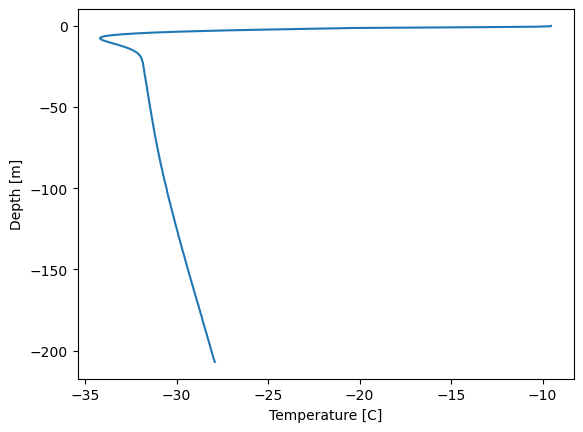

In [441]:
### Get real data ###

filepath = '/data/fast1/jm-scratch/data_proc.pkl'
file = open(filepath, 'rb')
data = pkl.load(file)

T_real = data['ALHIC1902_23_5min'][2].values
z_real = data['ALHIC1902_23_5min'][0].values

### Plot the real data! ###

fig, ax = plt.subplots()

ax.plot(T_real, z_real*-1)
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Depth [m]')

In [442]:
### Get the ranges and constants and things ###

tmax = 2023
tmin = 1873
zmax = z_real[-1]
dTdz = 0.026
nz = 99
nt = 199
alpha = 35
k = 2.22

In [443]:
### Do some resampling so the data matches the model shape ###
below_season = 20 # meters
spatial_sampling = 0.254 # meters
cutoff = int(below_season / spatial_sampling)
dz = zmax/(nz+1)

z = np.linspace(dz,zmax, nz+1)

spatial_sampling_model = zmax / nz
cutoff_model = int(below_season/ spatial_sampling_model)

f = interpolate.interp1d(z_real, T_real)

y = f(z) # Interpolating the real data to the model dimensions
yerr = [0.01] * len(y)

In [444]:
### Get the geometry of the surface conditions ###

t = np.linspace(tmin,tmax,nt)

Text(0, 0.5, 'Depth [m]')

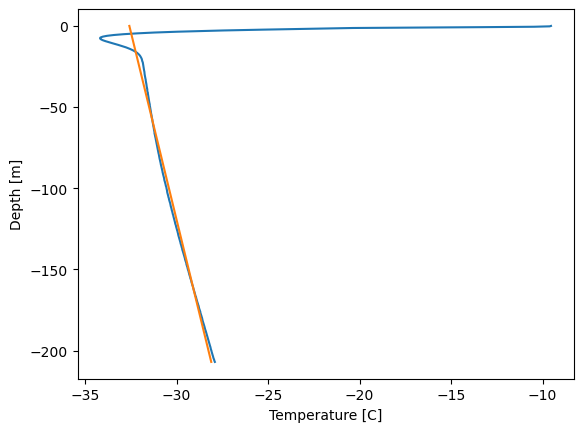

In [445]:
### Get the initial state ###
slope, b = np.polyfit(z_real[cutoff:], T_real[cutoff:], 1)

T_steadyState = slope * z_real + b

### Plot the real data and steady state! ###

fig, ax = plt.subplots()

ax.plot(T_real, z_real*-1)
ax.plot(T_steadyState, z_real*-1)
ax.set_xlabel('Temperature [C]')
ax.set_ylabel('Depth [m]')

(-0.5, 0.5)

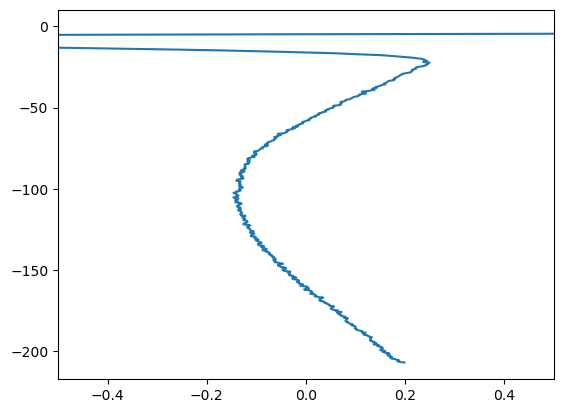

In [446]:
### Residual from the steady state (linear trend from below the seasonal signal) ###

T_steadyState_residual = T_real - T_steadyState

fig,ax = plt.subplots()
ax.plot(T_steadyState_residual, z_real*-1)
ax.set_xlim([-.5,.5])

(-0.5, 0.5)

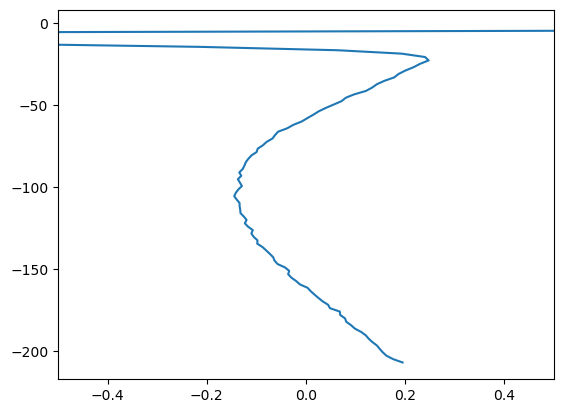

In [447]:
### Get the initial state downsampled ###
slope_down, b_down = np.polyfit(z[cutoff_model:], y[cutoff_model:], 1)

T_steadyState_down = slope_down * z + b_down

### Residual from the steady state (linear trend from below the seasonal signal) but downsampled to match the model###

T_steadyState_residual_down = y - T_steadyState_down

fig,ax = plt.subplots()
ax.plot(T_steadyState_residual_down, z*-1)
ax.set_xlim([-.5,.5])


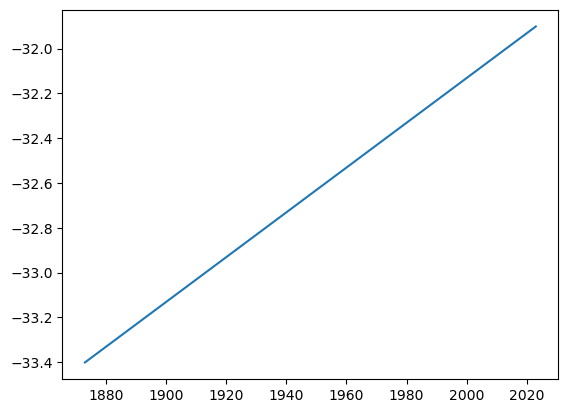

In [448]:
### Hand tune the temperature signal ###

mag = 1.5
temp = np.linspace(b+(-mag/2),b+(mag/2),nt) -0.07

fig,ax = plt.subplots()
ax.plot(t, temp)

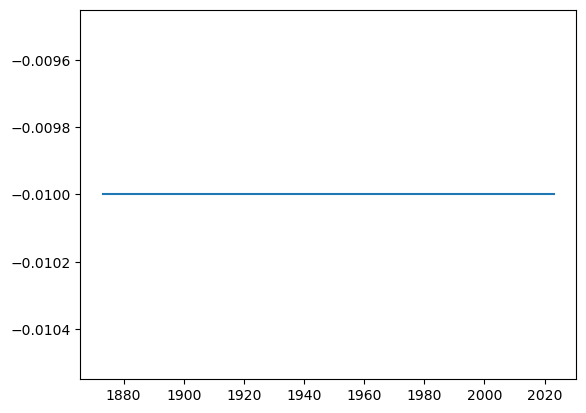

In [449]:
### Let's just make a constant accumulation rate right now ###
mag_ablation = -0.01


ablation = np.array([mag_ablation]*nt)
fig,ax = plt.subplots()
ax.plot(t, ablation)

In [450]:
### Run the model given these histories ###

U,time,z = heat_var_accum(temp,
                   ablation,
                     tmax = tmax,
                     tmin = tmin,
                     zmax = zmax,
                     dTdz = dTdz,
                     nz = nz,
                     nt = nt,
                     alpha = alpha)

model = U[:,-1]

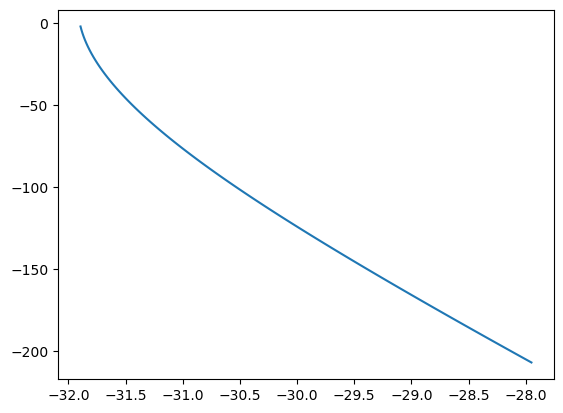

In [451]:
fig, ax = plt.subplots()

ax.plot(model, z*-1)

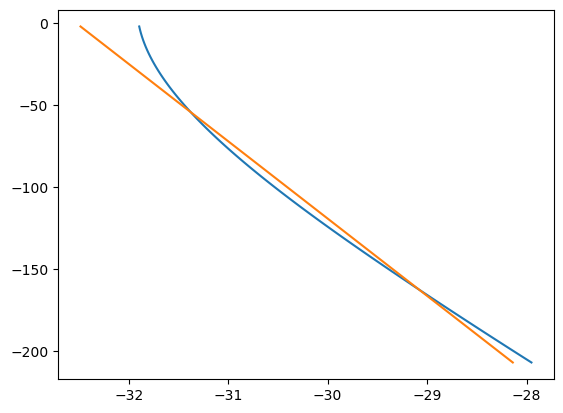

In [452]:
### Get the linear fit to the model ###
slope_model, b_model = np.polyfit(z[cutoff_model:], model[cutoff_model:], 1)

T_steadyState_model = slope_model * z + b_model

fig, ax = plt.subplots()

ax.plot(model, z*-1)
ax.plot(T_steadyState_model, z*-1)

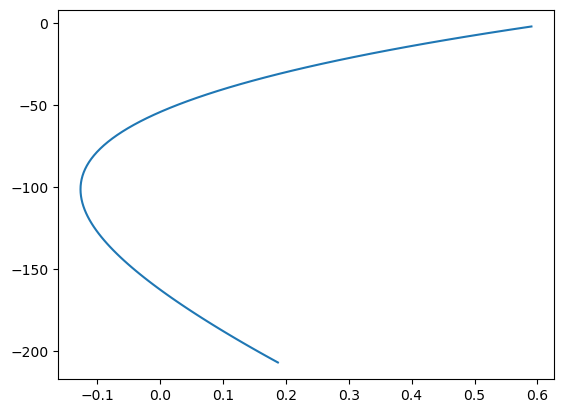

In [453]:
### Get the residual from the steady state of the model ###

T_steadyState_model_residual = model - T_steadyState_model

fig, ax = plt.subplots()
ax.plot(T_steadyState_model_residual,z*-1)

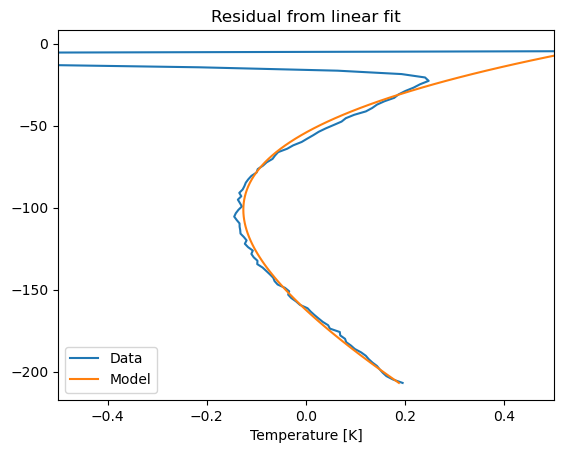

In [454]:
### NOW, COMPARE THE RESIDUALS FROM A STEADY STATE TO REAL DATA TO THE MODEL ###

fig, ax = plt.subplots()
ax.plot(T_steadyState_residual_down,z*-1, label = 'Data')
ax.plot(T_steadyState_model_residual,z*-1, label = 'Model')

ax.set_xlim([-0.5,0.5])
ax.set_title('Residual from linear fit')
ax.set_xlabel('Temperature [K]')
ax.legend()

Text(0.5, 1.0, 'Real temperatures')

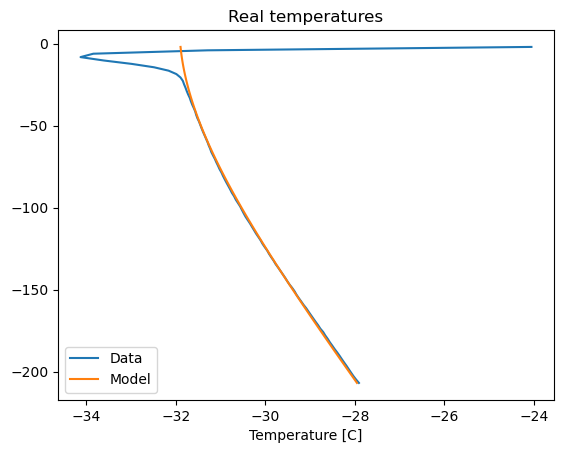

In [455]:
### NOW, COMPARE THE REAL DATA TO THE MODEL ###

fig, ax = plt.subplots()
ax.plot(y,z*-1, label = 'Data')
ax.plot(model,z*-1, label = 'Model')
ax.legend()

ax.set_xlabel('Temperature [C]')
ax.set_title('Real temperatures')

Text(0.5, 1.0, 'Residual (truth - model)')

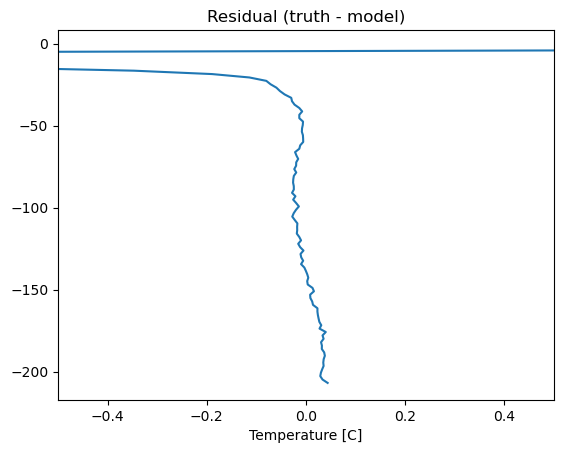

In [456]:
### NOW, COMPARE THE REAL DATA TO THE MODEL ###

fig, ax = plt.subplots()
ax.plot(y - model,z*-1, label = 'Residual')

ax.set_xlim([-0.5,0.5])

ax.set_xlabel('Temperature [C]')
ax.set_title('Residual (truth - model)')


## Can we do an emcee for surface temperature, geothermal flux and an ablation value?

In [586]:
### Functions to help us with the EMCEE work flow ###


def temp_history_getter(mean_temp, mag):
    """ 
    This function gives us a linear temperature history given
    a mean temperature and a magnitude of the warming.
    """
    return np.linspace(mean_temp+(-mag/2),mean_temp+(mag/2),nt)

def ablation_history_getter(ablation_rate):
    """
    This function gives us a time series of a contant ablation rate.
    """
    return np.array([ablation_rate]*nt)

def log_likelihood(theta, y, yerr):
    """
    This is the liklihood function by which we determine the fitness
    of the EMCEE model to the data.
    
    theta: This will consist of the mean temperature of the trend, magnitude of the trend 
            or rate, the ablation rate, and the geothermal heat flux in the form of a warming gradient.
    y: This is the true data.
    yerr: This is the error in the measurement of the true data (here we just take it as 0.01 K)
    """
    
    t_surf = temp_history_getter(theta[0], theta[1])
    ablation = ablation_history_getter(theta[2])
    U,time,z = heat_var_accum(t_surf,
                              ablation,
                              tmax = tmax,
                              tmin = tmin,
                              zmax = zmax,
                              dTdz = theta[3],
                              nz = nz,
                              nt = nt,
                              alpha = alpha)
    
    """
    Here, we will stack the both the actual temperatures and detrended temperatures so we can 
    combine the effect and the residuals.
    """
    
    model = U[cutoff_model:,-1]
    y_cut = y[cutoff_model:]
    
    model_detrend = detrend(U[cutoff_model:,-1])
    y_cut_detrend = detrend(y[cutoff_model:])
    
    model_cut_total = np.append(model, model_detrend)
    y_cut_total = np.append(y_cut, y_cut_detrend)
    
    #sigma2 = .01**2 + model**2 * np.exp(2 * 0)
    sigma2 = 0.01**2
    
    return -0.5 * np.sum((y_cut_total - model_cut_total) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    
    """
    This function will limit where our walkers will investigate.
    Here, we make our prior assumptions about the possible values for the model.
    """
    
    lower_bound_temp, upper_bound_temp = -36.0, -28.0
    lower_bound_mag, upper_bound_mag = -4.0, 4.0
    lower_bound_ablation, upper_bound_ablation = -0.2, 0.0
    lower_bound_geoflux, upper_bound_geoflux = 0.01, 0.05
    
#     if all(lower_bound_temp <= x <= upper_bound_temp for x in theta[0]) and\
#     all(lower_bound_mag <= x <= upper_bound_mag for x in theta[1]) and\
#     all(lower_bound_ablation <= x <= upper_bound_ablation for x in theta[2]) and\
#     all(lower_bound_geoflux <= x <= upper_bound_geoflux for x in theta[3]):
    if lower_bound_temp <= theta[0] <= upper_bound_temp and\
    lower_bound_mag <= theta[1] <= upper_bound_mag and\
    lower_bound_ablation <= theta[2] <= upper_bound_ablation  and\
    lower_bound_geoflux <= theta[3] <= upper_bound_geoflux:
        return 0.0
    else:
        return -np.inf

def log_probability(theta, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, y, yerr)

def foreword_model_getter(theta):
    """
    This function runs the foreword model and gets the time series for the proposed temp history
    and ablation.
    """
    
    t_surf = temp_history_getter(theta[0], theta[1])
    ablation = ablation_history_getter(theta[2])
    U,time,z = heat_var_accum(t_surf,
                              ablation,
                              tmax = tmax,
                              tmin = tmin,
                              zmax = zmax,
                              dTdz = theta[3],
                              nz = nz,
                              nt = nt,
                              alpha = alpha)
    
    """
    Here, we will stack the both the actual temperatures and detrended temperatures so we can 
    combine the effect and the residuals.
    """
    
    model = U[cutoff_model:,-1]

    
    model_detrend = detrend(U[cutoff_model:,-1])

    
    return U[:,-1], model_detrend, t_surf, ablation


In [587]:
mean_temp_init = b # mean surface temp from a linear trend of the profile
mag_trend_init = 1.5 # hand tuned value
ablation_init  = -0.01 # accepted value for ablation in Allan Hills
geoflux = 0.026 # gradient value from hand tuning

param_init = np.array([mean_temp_init, mag_trend_init, ablation_init, geoflux])

In [588]:
num_resets = 25



pos = param_init + np.random.randn(num_resets, len(param_init)) * np.array([1e-1, 1e-1, 1e-2, 1e-2])

nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,args=(y, yerr), 
)
sampler.run_mcmc(pos, 200, progress=True);

100%|██████████| 200/200 [22:45<00:00,  6.83s/it]


In [589]:
### Print the mean acceptance rate ###
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.485


In [590]:
flat_samples = sampler.get_chain(discard=0, thin=15, flat=True)
print(flat_samples.shape)

(325, 4)


In [583]:

labels = ['Mean Temp', 'Mag of Temp Change', 'Accum. Rate', 'Bed Temp Gradient']

100%|██████████| 325/325 [01:39<00:00,  3.26it/s]


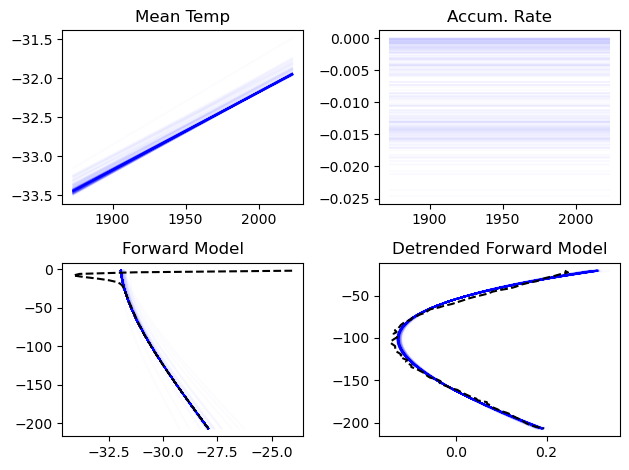

In [591]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

for i in tqdm(flat_samples):
    foreword_model, model_detrended, t_surf, ablation = foreword_model_getter(i)
    
    ax1.plot(t, t_surf, color = 'blue', alpha = 0.01, label=labels[0])
    ax2.plot(t, ablation, color = 'blue', alpha = 0.01, label=labels[2])
    
    ax3.plot(foreword_model,z*-1, color = 'blue', alpha=0.01, label = 'Forward Model')
    ax4.plot(model_detrended,z[cutoff_model:]*-1, color = 'blue', alpha=0.01, label = 'Detrended Forward model')
    
    ax1.set_title(labels[0])
    ax2.set_title(labels[2])
    ax3.set_title('Forward Model')
    ax4.set_title('Detrended Forward Model')
    
ax3.plot(y,z*-1, label = 'Data', color='black',ls='--')
ax4.plot(detrend(y[cutoff_model:]),z[cutoff_model:]*-1, label = 'Data', color='black',ls='--')
plt.tight_layout()

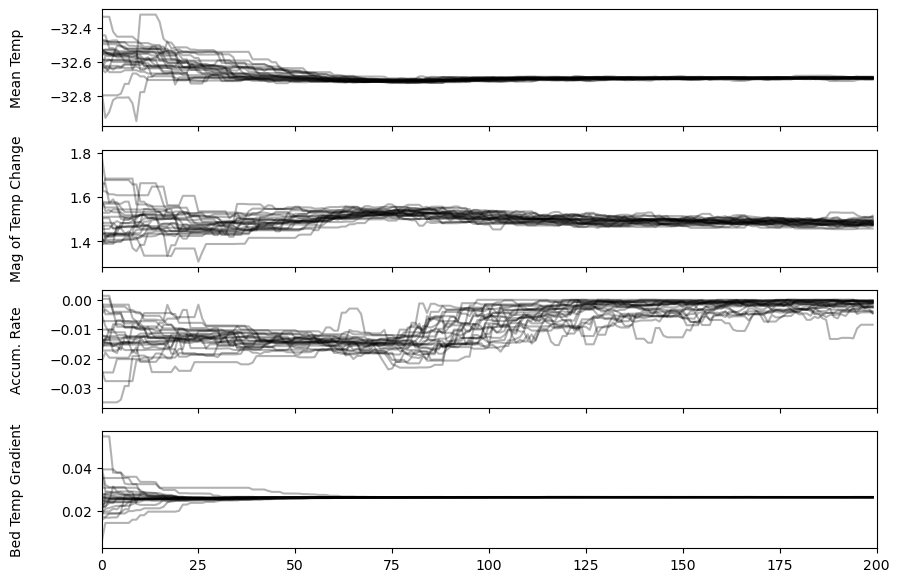

In [592]:
### Investigate the walkers ###


samples = sampler.get_chain()

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)


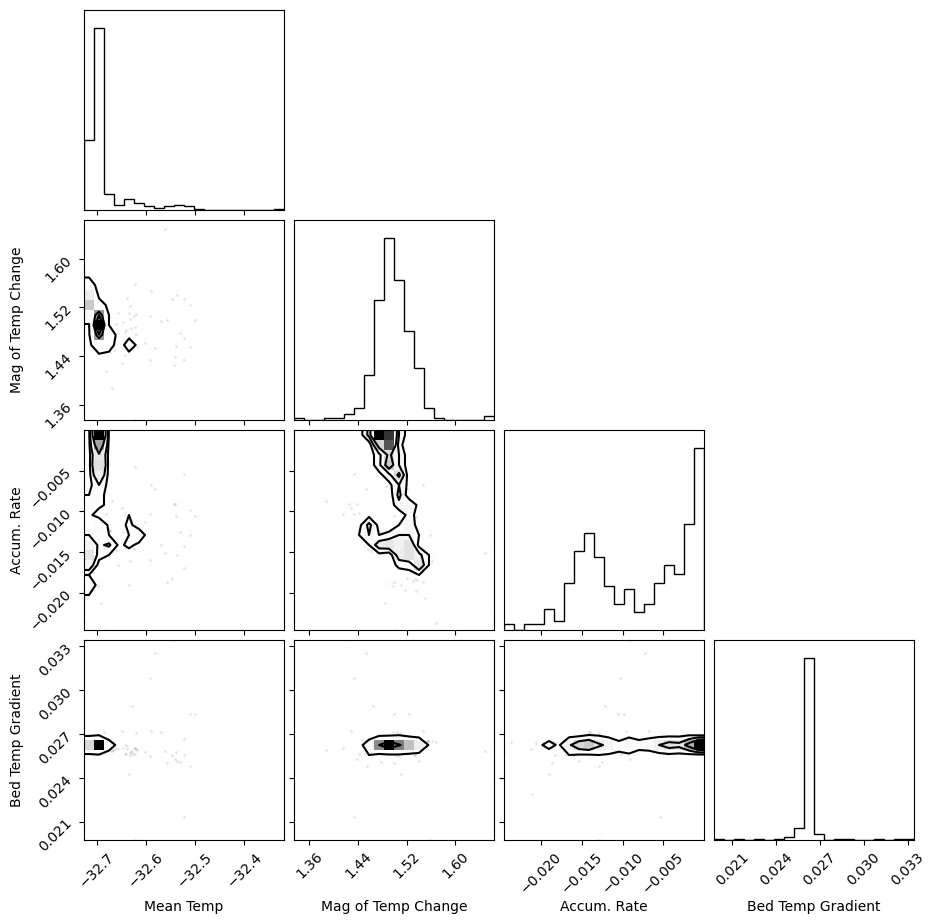

In [593]:
import corner

fig = corner.corner(
    flat_samples, labels = labels
);